<a href="https://colab.research.google.com/github/hoky1227/Transformer_based-recommendation/blob/main/Transformer_e_commerce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gdrive 연동

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

path = '/content/drive/MyDrive/'

Mounted at /content/drive


# Import Modules

In [ ]:
import numpy as np
import pandas as pd
from dateutil.parser import parse
from tqdm import tqdm_notebook
import tqdm
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow as tf
import re
import torch
from gensim.models import Word2Vec
import math
from numpy.linalg import norm

import warnings 

warnings.filterwarnings('ignore')

#재현성을 위해 seed 고정

np.random.seed(2021)
tf.random.set_seed(2021)

# Data 전처리

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/2017online retail.csv")

print(df.isnull().sum())
df.dropna(inplace=True)
print(df.duplicated().sum())
df.drop_duplicates(inplace=True)
df.head()

Customer       42970
Payment Way        0
Invoice            0
ItemCode           0
Detail          1745
Date               0
Amount             0
Price              0
dtype: int64
1458


,Customer,Payment Way,Invoice,ItemCode,Detail,Date,Amount,Price
0,37593.0,Skrill,C514216,22406,MONEY BOX KINGS CHOICE DESIGN,2017/6/30 17:38,-1,1.25
1,37593.0,Skrill,C514216,22056,CERAMIC PLATE LOVE HEART DESIGN,2017/6/30 17:38,-1,1.49
2,37593.0,Skrill,C514216,21844,RED RETROSPOT MUG,2017/6/30 17:38,-1,2.95
3,37593.0,Skrill,C514216,22073,RED RETROSPOT STORAGE JAR,2017/6/30 17:38,-1,3.75
4,37593.0,Credit,C514216,22059,CERAMIC STRWBERRY DESIGN MUG,2017/6/30 17:38,-2,1.49


In [ ]:
df.drop(['Payment Way', 'Date'],axis=1, inplace=True)
df.head()

,Customer,Invoice,ItemCode,Detail,Amount,Price
0,37593.0,C514216,22406,MONEY BOX KINGS CHOICE DESIGN,-1,1.25
1,37593.0,C514216,22056,CERAMIC PLATE LOVE HEART DESIGN,-1,1.49
2,37593.0,C514216,21844,RED RETROSPOT MUG,-1,2.95
3,37593.0,C514216,22073,RED RETROSPOT STORAGE JAR,-1,3.75
4,37593.0,C514216,22059,CERAMIC STRWBERRY DESIGN MUG,-2,1.49


In [ ]:
def check(): # Detail이 대문자로 이루어져 있어 소문자가 포함될 경우 이상값일 가능성이 있어 검증하는 함수
    df['Detail'] = df['Detail'].str.strip()
    Detail = df['Detail'].unique()
    for i in Detail:
        if i.isupper() == False:
            print(i)

check()

Manual
BAG 250g SWIRLY MARBLES
Discount
Adjustment by Peter on 24/05/2010 1
BAG 125g SWIRLY MARBLES
POLYESTER FILLER PAD 65CMx65CM
Bank Charges
POLYESTER FILLER PAD 40x40cm
Adjustment by john on 26/01/2010 17
Adjustment by john on 26/01/2010 16
Adjust bad debt
FOLK ART GREETING CARD,pack/12
POLYESTER FILLER PAD 45x45cm
Adjustment by Peter on Jun 25 2010
ESSENTIAL BALM 3.5g TIN IN ENVELOPE
SET Of 6 SOLDIER SKITTLES
POLYESTER FILLER PAD 30CMx30CM
THE KING GIFT BAG 25x24x12cm
POLYESTER FILLER PAD 45x30cm
This is a test product.
POLYESTER FILLER PAD 60x40cm


In [ ]:
def check10():# 대문자로만 이루어진 이상값 존재 확인을 위해 글자수 10 이하 확인
    Detail = df['Detail'].unique()
    for i in Detail:
        if len(i) <= 10:
            print(i)

check10()

Manual
POSTAGE
Discount
CARRIAGE
SPOTS MUG
PHOTO CUBE
SOMBRERO
BINGO SET
SPACE OWL
CAT BOWL
SPACE FROG
DAISY RING


In [ ]:
# 이상값 제거
idx = df[df['Amount'] <= 0.].index
df.drop(idx, inplace=True)
l = ['Manual', 'This is a test product.', 'Discount', 'Adjustment by Peter on 24/05/2010 1',\
     'Bank Charges', 'Adjustment by john on 26/01/2010 17',  'Adjustment by john on 26/01/2010 16', 'Adjust bad debt', 'Adjustment by Peter on Jun 25 2010', 'POSTAGE', 'CARRIAGE']
for v in l:
    idx2 = df[df['Detail'] == v].index
    df.drop(idx2, inplace=True)
idx3 = df[df['Price'] <= 0.].index
df.drop(idx3, inplace=True)

df.describe()

,Customer,Amount,Price
count,161040.000000,161040.000000,161040.000000
mean,35334.207570,14.045293,3.051039
std,1673.922109,123.241911,3.435328
min,32346.000000,1.000000,0.001000
25%,33976.000000,2.000000,1.250000
50%,35248.000000,5.000000,1.950000
75%,36805.000000,12.000000,3.750000
max,38287.000000,19152.000000,125.000000


In [ ]:
check()

BAG 250g SWIRLY MARBLES
FOLK ART GREETING CARD,pack/12
POLYESTER FILLER PAD 45x45cm
POLYESTER FILLER PAD 40x40cm
BAG 125g SWIRLY MARBLES
POLYESTER FILLER PAD 65CMx65CM
ESSENTIAL BALM 3.5g TIN IN ENVELOPE
SET Of 6 SOLDIER SKITTLES
POLYESTER FILLER PAD 30CMx30CM
THE KING GIFT BAG 25x24x12cm
POLYESTER FILLER PAD 45x30cm
POLYESTER FILLER PAD 60x40cm


In [ ]:
check10()

PHOTO CUBE
SOMBRERO
BINGO SET
SPACE OWL
CAT BOWL
SPOTS MUG
SPACE FROG
DAISY RING


In [ ]:
df.drop(['Amount', 'Price', 'ItemCode'],axis=1, inplace=True)
df.head()

,Customer,Invoice,Detail
4492,34882.0,264212,COLOUR GLASS T-LIGHT HOLDER HANGING
4493,34882.0,264212,PORCELAIN HANGING BELL SMALL
4494,34882.0,264212,NATURAL SLATE HEART CHALKBOARD
4496,34882.0,264212,PORCELAIN HANGING BELL LARGE
4497,34882.0,264212,ENAMEL WATERING CAN CREAM


In [ ]:
detail = df['Detail'].unique()

In [ ]:
def sortdf(data, column): # 정렬 함수
    data.sort_values(column, inplace=True)
    data.reset_index(inplace=True)
    data.pop('index')
    return data

## Customer 기준 history

In [ ]:
df_customer = df.copy() # 기존 데이터 오염을 막기 위해 복사, 기존 데이터는 이후 재사용
sortdf(df_customer, ['Customer'])
df_customer.pop('Invoice')
df_customer.head()

,Customer,Detail
0,32346.0,DOORMAT HOME SWEET HOME BLUE
1,32346.0,DOORMAT SPOTTY HOME SWEET HOME
2,32346.0,DOORMAT WELCOME TO OUR HOME
3,32346.0,DOORMAT I LOVE LONDON
4,32346.0,DOORMAT CHRISTMAS VILLAGE


In [ ]:
df2 = pd.DataFrame(columns=df_customer.columns) # Product2Vec 학습용 Customer 기준 history
values = df_customer['Customer'].value_counts().index.sort_values()

for i, v in enumerate(values):
    df2.loc[i] = (v, '&&'.join(df_customer[df_customer['Customer'] == v]['Detail']))
df2

,Customer,Detail
0,32346.0,DOORMAT HOME SWEET HOME BLUE&&DOORMAT SPOTTY H...
1,32349.0,RETRO SPOT LARGE MILK JUG&&POLKADOT CUTLERY 24...
2,32355.0,GOLD TEDDY BEAR&&OPULENT VELVET SET/3 CANDLES&...
3,32358.0,JUMBO SHOPPER VINTAGE RED PAISLEY&&GARDEN PATH...
4,32359.0,SET OF 2 WOODEN MARKET CRATES&&OLD DOC RUSSEL ...
...,...,...
2727,38276.0,LUNCH BAG SPACEBOY DESIGN&&SET OF 72 SKULL PAP...
2728,38281.0,TEA PARTY BIRTHDAY CARD&&LUNCH BAG PINK RETROS...
2729,38283.0,SMALL POPCORN HOLDER&&ASSORTED ICE CREAM FRIDG...
2730,38285.0,GLASS HEART T-LIGHT HOLDER&&SMALL GLASS SUNDAE...


In [ ]:
ds = df2.copy()
ds

,Customer,Detail
0,32346.0,DOORMAT HOME SWEET HOME BLUE&&DOORMAT SPOTTY H...
1,32349.0,RETRO SPOT LARGE MILK JUG&&POLKADOT CUTLERY 24...
2,32355.0,GOLD TEDDY BEAR&&OPULENT VELVET SET/3 CANDLES&...
3,32358.0,JUMBO SHOPPER VINTAGE RED PAISLEY&&GARDEN PATH...
4,32359.0,SET OF 2 WOODEN MARKET CRATES&&OLD DOC RUSSEL ...
...,...,...
2727,38276.0,LUNCH BAG SPACEBOY DESIGN&&SET OF 72 SKULL PAP...
2728,38281.0,TEA PARTY BIRTHDAY CARD&&LUNCH BAG PINK RETROS...
2729,38283.0,SMALL POPCORN HOLDER&&ASSORTED ICE CREAM FRIDG...
2730,38285.0,GLASS HEART T-LIGHT HOLDER&&SMALL GLASS SUNDAE...


In [ ]:
ds1 = ds['Detail'].str.split('&&')
print(ds1[0][-1])
print(ds1[0][-2])
ds1

RED SPOTTY CHILDS UMBRELLA
DOORMAT UNION JACK GUNS AND ROSES


0       [DOORMAT HOME SWEET HOME BLUE, DOORMAT SPOTTY ...
1       [RETRO SPOT LARGE MILK JUG, POLKADOT CUTLERY 2...
2       [GOLD TEDDY BEAR, OPULENT VELVET SET/3 CANDLES...
3       [JUMBO SHOPPER VINTAGE RED PAISLEY, GARDEN PAT...
4       [SET OF 2 WOODEN MARKET CRATES, OLD DOC RUSSEL...
                              ...                        
2727    [LUNCH BAG SPACEBOY DESIGN, SET OF 72 SKULL PA...
2728    [TEA PARTY BIRTHDAY CARD, LUNCH BAG PINK RETRO...
2729    [SMALL POPCORN HOLDER, ASSORTED ICE CREAM FRID...
2730    [GLASS HEART T-LIGHT HOLDER, SMALL GLASS SUNDA...
2731    [S/4 PINK FLOWER CANDLES IN BOWL, GARLAND, MAG...
Name: Detail, Length: 2732, dtype: object

In [ ]:
label = []
for i in range(len(ds1)):
    l = ds1[i][-1]
    ds1[i].pop()
    label.append(l)

display(ds1.head())
print(label[:5])
ds1[0][-1]

0    [DOORMAT HOME SWEET HOME BLUE, DOORMAT SPOTTY ...
1    [RETRO SPOT LARGE MILK JUG, POLKADOT CUTLERY 2...
2    [GOLD TEDDY BEAR, OPULENT VELVET SET/3 CANDLES...
3    [JUMBO SHOPPER VINTAGE RED PAISLEY, GARDEN PAT...
4    [SET OF 2 WOODEN MARKET CRATES, OLD DOC RUSSEL...
Name: Detail, dtype: object

['RED SPOTTY CHILDS UMBRELLA', 'SET/6 RED SPOTTY PAPER CUPS', 'KIDS RAIN MAC BLUE', 'ASSORTED CHEESE FRIDGE MAGNETS', 'LAUNDRY 15C METAL SIGN']


'DOORMAT UNION JACK GUNS AND ROSES'

In [ ]:
ds1 = ds1.apply(lambda x: '&&'.join(map(str, x)))
ds1.head()

0    DOORMAT HOME SWEET HOME BLUE&&DOORMAT SPOTTY H...
1    RETRO SPOT LARGE MILK JUG&&POLKADOT CUTLERY 24...
2    GOLD TEDDY BEAR&&OPULENT VELVET SET/3 CANDLES&...
3    JUMBO SHOPPER VINTAGE RED PAISLEY&&GARDEN PATH...
4    SET OF 2 WOODEN MARKET CRATES&&OLD DOC RUSSEL ...
Name: Detail, dtype: object

In [ ]:
ds['Detail'] = ds1
ds['label'] = label
ds

,Customer,Detail,label
0,32346.0,DOORMAT HOME SWEET HOME BLUE&&DOORMAT SPOTTY H...,RED SPOTTY CHILDS UMBRELLA
1,32349.0,RETRO SPOT LARGE MILK JUG&&POLKADOT CUTLERY 24...,SET/6 RED SPOTTY PAPER CUPS
2,32355.0,GOLD TEDDY BEAR&&OPULENT VELVET SET/3 CANDLES&...,KIDS RAIN MAC BLUE
3,32358.0,JUMBO SHOPPER VINTAGE RED PAISLEY&&GARDEN PATH...,ASSORTED CHEESE FRIDGE MAGNETS
4,32359.0,SET OF 2 WOODEN MARKET CRATES&&OLD DOC RUSSEL ...,LAUNDRY 15C METAL SIGN
...,...,...,...
2727,38276.0,LUNCH BAG SPACEBOY DESIGN&&SET OF 72 SKULL PAP...,LUNCH BAG BLACK SKULL.
2728,38281.0,TEA PARTY BIRTHDAY CARD&&LUNCH BAG PINK RETROS...,SPACEBOY BIRTHDAY CARD
2729,38283.0,SMALL POPCORN HOLDER&&ASSORTED ICE CREAM FRIDG...,RED SPOTTY CHILDS APRON
2730,38285.0,GLASS HEART T-LIGHT HOLDER&&SMALL GLASS SUNDAE...,CAKE STAND VICTORIAN FILIGREE SMALL


In [ ]:
ds.isnull().sum()

Customer    0
Detail      0
label       0
dtype: int64

In [ ]:
de = ds['Detail'].unique()
for i in de:
    if len(i) <= 5:
        print(str(i))

In [ ]:
# 위의 결과로부터 ''값이 존재하여 제거
idx2 = ds[ds['Detail'] == ''].index
ds.drop(idx2, inplace=True)

In [ ]:
ds

,Customer,Detail,label
0,32346.0,DOORMAT HOME SWEET HOME BLUE&&DOORMAT SPOTTY H...,RED SPOTTY CHILDS UMBRELLA
1,32349.0,RETRO SPOT LARGE MILK JUG&&POLKADOT CUTLERY 24...,SET/6 RED SPOTTY PAPER CUPS
2,32355.0,GOLD TEDDY BEAR&&OPULENT VELVET SET/3 CANDLES&...,KIDS RAIN MAC BLUE
3,32358.0,JUMBO SHOPPER VINTAGE RED PAISLEY&&GARDEN PATH...,ASSORTED CHEESE FRIDGE MAGNETS
4,32359.0,SET OF 2 WOODEN MARKET CRATES&&OLD DOC RUSSEL ...,LAUNDRY 15C METAL SIGN
...,...,...,...
2727,38276.0,LUNCH BAG SPACEBOY DESIGN&&SET OF 72 SKULL PAP...,LUNCH BAG BLACK SKULL.
2728,38281.0,TEA PARTY BIRTHDAY CARD&&LUNCH BAG PINK RETROS...,SPACEBOY BIRTHDAY CARD
2729,38283.0,SMALL POPCORN HOLDER&&ASSORTED ICE CREAM FRIDG...,RED SPOTTY CHILDS APRON
2730,38285.0,GLASS HEART T-LIGHT HOLDER&&SMALL GLASS SUNDAE...,CAKE STAND VICTORIAN FILIGREE SMALL


In [ ]:
ds_customer = ds # 명확한 명칭으로 변경

## Invoice 기준 history

In [ ]:
df_invoice = df.copy()
df_invoice['Invoice'] = df_invoice['Invoice'].apply(lambda x: str(x))
sortdf(df_invoice, ['Invoice'])
df_invoice.head()

,Customer,Invoice,Detail
0,34590.0,243414,HAND OPEN SHAPE GOLD
1,34590.0,243414,RETRO SPOT MUG
2,34590.0,243414,RETRO SPOT SUGAR JAM BOWL
3,34590.0,243414,NEW ENGLAND CERAMIC CAKE SERVER
4,34590.0,243414,RETRO SPOT TRADITIONAL TEAPOT


In [ ]:
Invoice = df_invoice['Invoice'].unique()
Invoice = sorted(Invoice)
len(Invoice)

7557

In [ ]:
df3 = pd.DataFrame(columns=['Invoice', 'Detail']) #  Transformer 학습용 Invoice 기준 history
values = df_invoice['Invoice'].value_counts().index.sort_values()

for i, v in enumerate(tqdm.tqdm(values)):
    df3.loc[i] = (v, '&&'.join(df_invoice[df_invoice['Invoice'] == v]['Detail']))
df3

100%|██████████| 7557/7557 [01:24<00:00, 89.96it/s]


,Invoice,Detail
0,243414,HAND OPEN SHAPE GOLD&&RETRO SPOT MUG&&RETRO SP...
1,243427,MOROCCAN TEA GLASS&&BLACK FLOWER CANDLE PLATE&...
2,243428,LUNCHBOX WITH CUTLERY FAIRY CAKES&&STRAWBERRY ...
3,243432,RED WOOLLY HOTTIE WHITE HEART.&&CERAMIC CAKE D...
4,243433,STRAWBERRY CERAMIC TRINKET BOX&&JUMBO BAG BAR...
...,...,...
7552,264208,ASSORTED COLOUR BIRD ORNAMENT&&VICTORIAN GLASS...
7553,264209,PACK OF 60 PINK PAISLEY CAKE CASES&&WASHROOM M...
7554,264210,GLASS JAR DIGESTIVE BISCUITS&&BLUE STRIPE CERA...
7555,264211,PICNIC BASKET WICKER SMALL&&NATURAL SLATE HEAR...


In [ ]:
df3.pop('Invoice')
df3

,Detail
0,HAND OPEN SHAPE GOLD&&RETRO SPOT MUG&&RETRO SP...
1,MOROCCAN TEA GLASS&&BLACK FLOWER CANDLE PLATE&...
2,LUNCHBOX WITH CUTLERY FAIRY CAKES&&STRAWBERRY ...
3,RED WOOLLY HOTTIE WHITE HEART.&&CERAMIC CAKE D...
4,STRAWBERRY CERAMIC TRINKET BOX&&JUMBO BAG BAR...
...,...
7552,ASSORTED COLOUR BIRD ORNAMENT&&VICTORIAN GLASS...
7553,PACK OF 60 PINK PAISLEY CAKE CASES&&WASHROOM M...
7554,GLASS JAR DIGESTIVE BISCUITS&&BLUE STRIPE CERA...
7555,PICNIC BASKET WICKER SMALL&&NATURAL SLATE HEAR...


In [ ]:
df_series = df3['Detail'].str.split('&&')
df_series[0]

['HAND OPEN SHAPE GOLD',
 'RETRO SPOT MUG',
 'RETRO SPOT SUGAR JAM BOWL',
 'NEW ENGLAND CERAMIC CAKE SERVER',
 'RETRO SPOT TRADITIONAL TEAPOT',
 'RETRO SPOT LARGE MILK JUG']

In [ ]:
# Invoice를 4+1로 자르는 함수

sequence_length = 5
step_size = 2

# [4, 4, 5, 5, 6, 6]이라면, 아래 함수를 통해
# [[4, 4, 5, 5], [5, 5, 6, 6]]으로 다시 만들어집니다.
def create_sequences(values, window_size, step_size):
    sequences = []
    start_index = 0
    while True:
        end_index = start_index + window_size
        seq = values[start_index:end_index]
        # 뒤에 남은 데이터가 window_size보다 작으면 중지합니다.
        if len(seq) < window_size:
            seq = values[-window_size:]
            # window_size와 같으면 list에 붙여줍니다.
            if len(seq) == window_size:
                sequences.append(seq)
            break
        sequences.append(seq)
        start_index += step_size
    return sequences

In [ ]:
for i, v in enumerate(df_series):
    df_series[i] = create_sequences(v, sequence_length, step_size)
df_series[0]

[['HAND OPEN SHAPE GOLD',
  'RETRO SPOT MUG',
  'RETRO SPOT SUGAR JAM BOWL',
  'NEW ENGLAND CERAMIC CAKE SERVER',
  'RETRO SPOT TRADITIONAL TEAPOT'],
 ['RETRO SPOT MUG',
  'RETRO SPOT SUGAR JAM BOWL',
  'NEW ENGLAND CERAMIC CAKE SERVER',
  'RETRO SPOT TRADITIONAL TEAPOT',
  'RETRO SPOT LARGE MILK JUG']]

In [ ]:
df_list = []
for v in df_series:
    for value in v:
        df_list.append(value)
df_list[:2]

[['HAND OPEN SHAPE GOLD',
  'RETRO SPOT MUG',
  'RETRO SPOT SUGAR JAM BOWL',
  'NEW ENGLAND CERAMIC CAKE SERVER',
  'RETRO SPOT TRADITIONAL TEAPOT'],
 ['RETRO SPOT MUG',
  'RETRO SPOT SUGAR JAM BOWL',
  'NEW ENGLAND CERAMIC CAKE SERVER',
  'RETRO SPOT TRADITIONAL TEAPOT',
  'RETRO SPOT LARGE MILK JUG']]

In [ ]:
label_list = []

for i in range(len(df_list)):
    l = df_list[i][-1]
    df_list[i].pop()
    label_list.append(l)
label_list[:2]

['RETRO SPOT TRADITIONAL TEAPOT', 'RETRO SPOT LARGE MILK JUG']

In [ ]:
df_new = pd.DataFrame(columns=['Detail', 'label'])
df_new['Detail'] = df_list
df_new['label'] = label_list
df_new

,Detail,label
0,"[HAND OPEN SHAPE GOLD, RETRO SPOT MUG, RETRO S...",RETRO SPOT TRADITIONAL TEAPOT
1,"[RETRO SPOT MUG, RETRO SPOT SUGAR JAM BOWL, NE...",RETRO SPOT LARGE MILK JUG
2,"[MOROCCAN TEA GLASS, BLACK FLOWER CANDLE PLATE...",CERAMIC CAKE DESIGN SPOTTED PLATE
3,"[BLACK SILOUETTE CANDLE PLATE, VICTORIAN GLASS...",SAVE THE PLANET COTTON TOTE BAG
4,"[CERAMIC CAKE DESIGN SPOTTED PLATE, PINK CLEAR...",STRAWBERRY CERAMIC TRINKET BOX
...,...,...
74502,"[UNION STRIPE WITH FRINGE HAMMOCK, RED/CREAM ...",WHITE HANGING HEART T-LIGHT HOLDER
74503,"[OCEAN STRIPE HAMMOCK, BLUE/CREAM STRIPE FRING...",ENAMEL WATERING CAN CREAM
74504,"[WHITE HANGING HEART T-LIGHT HOLDER, BAG 250g ...",NATURAL SLATE HEART CHALKBOARD
74505,"[ENAMEL WATERING CAN CREAM, PORCELAIN HANGING ...",COLOUR GLASS T-LIGHT HOLDER HANGING


In [ ]:
df_new['Detail'] = df_new['Detail'].apply(lambda x: '&&'.join(map(str, x)))
df_new

,Detail,label
0,HAND OPEN SHAPE GOLD&&RETRO SPOT MUG&&RETRO SP...,RETRO SPOT TRADITIONAL TEAPOT
1,RETRO SPOT MUG&&RETRO SPOT SUGAR JAM BOWL&&NEW...,RETRO SPOT LARGE MILK JUG
2,MOROCCAN TEA GLASS&&BLACK FLOWER CANDLE PLATE&...,CERAMIC CAKE DESIGN SPOTTED PLATE
3,BLACK SILOUETTE CANDLE PLATE&&VICTORIAN GLASS ...,SAVE THE PLANET COTTON TOTE BAG
4,CERAMIC CAKE DESIGN SPOTTED PLATE&&PINK CLEAR ...,STRAWBERRY CERAMIC TRINKET BOX
...,...,...
74502,UNION STRIPE WITH FRINGE HAMMOCK&&RED/CREAM S...,WHITE HANGING HEART T-LIGHT HOLDER
74503,OCEAN STRIPE HAMMOCK&&BLUE/CREAM STRIPE FRINGE...,ENAMEL WATERING CAN CREAM
74504,WHITE HANGING HEART T-LIGHT HOLDER&&BAG 250g S...,NATURAL SLATE HEART CHALKBOARD
74505,ENAMEL WATERING CAN CREAM&&PORCELAIN HANGING B...,COLOUR GLASS T-LIGHT HOLDER HANGING


In [ ]:
print(df_new.isnull().sum())
df_new.dropna(inplace=True)

Detail    0
label     0
dtype: int64


In [ ]:
print(df_new.duplicated().sum())
df_new.drop_duplicates(inplace=True)
df_new.reset_index(inplace=True)
df_new.pop('index')
df_new

3302


,Detail,label
0,HAND OPEN SHAPE GOLD&&RETRO SPOT MUG&&RETRO SP...,RETRO SPOT TRADITIONAL TEAPOT
1,RETRO SPOT MUG&&RETRO SPOT SUGAR JAM BOWL&&NEW...,RETRO SPOT LARGE MILK JUG
2,MOROCCAN TEA GLASS&&BLACK FLOWER CANDLE PLATE&...,CERAMIC CAKE DESIGN SPOTTED PLATE
3,BLACK SILOUETTE CANDLE PLATE&&VICTORIAN GLASS ...,SAVE THE PLANET COTTON TOTE BAG
4,CERAMIC CAKE DESIGN SPOTTED PLATE&&PINK CLEAR ...,STRAWBERRY CERAMIC TRINKET BOX
...,...,...
71200,WOODEN SKITTLES GARDEN SET&&DOORMAT UNION FLAG...,WOODEN CROQUET GARDEN SET
71201,UNION STRIPE WITH FRINGE HAMMOCK&&RED/CREAM S...,WHITE HANGING HEART T-LIGHT HOLDER
71202,OCEAN STRIPE HAMMOCK&&BLUE/CREAM STRIPE FRINGE...,ENAMEL WATERING CAN CREAM
71203,WHITE HANGING HEART T-LIGHT HOLDER&&BAG 250g S...,NATURAL SLATE HEART CHALKBOARD


In [ ]:
ds_invoice = df_new # 명확한 명칭으로 변경

# Transformer

In [ ]:
data = ds_invoice

data = data.sample(frac=1).reset_index(drop=True)
data.head()

,Detail,label
0,JUMBO BAG RED WHITE SPOTTY&&JUMBO BAG PINK WIT...,LUNCH BAG PINK RETROSPOT
1,PLEASE ONE PERSON METAL SIGN&&NATURAL SLATE HE...,NATURAL SLATE CHALKBOARD LARGE
2,JUMBO BAG WOODLAND ANIMALS&&STRAWBERRY CANDY B...,WOODLAND CHARLOTTE BAG
3,PINK DOUGHNUT TRINKET POT&&VINTAGE HEADS AND T...,COFFEE MUG BLUE PAISLEY DESIGN
4,3D HEARTS HONEYCOMB PAPER GARLAND&&SPOTTY HO...,ORIENTAL BLUE C/COVER


In [ ]:
train_df = data.copy()
train_df.rename(columns = {'Detail':'train'}, inplace=True)
train_df.head()

,train,label
0,JUMBO BAG RED WHITE SPOTTY&&JUMBO BAG PINK WIT...,LUNCH BAG PINK RETROSPOT
1,PLEASE ONE PERSON METAL SIGN&&NATURAL SLATE HE...,NATURAL SLATE CHALKBOARD LARGE
2,JUMBO BAG WOODLAND ANIMALS&&STRAWBERRY CANDY B...,WOODLAND CHARLOTTE BAG
3,PINK DOUGHNUT TRINKET POT&&VINTAGE HEADS AND T...,COFFEE MUG BLUE PAISLEY DESIGN
4,3D HEARTS HONEYCOMB PAPER GARLAND&&SPOTTY HO...,ORIENTAL BLUE C/COVER


## 학습 데이터의 토큰 갯수 분포 확인

In [ ]:
train_df['token_len'] = [len(sum([i.split(' ') for i in aaa.split('&&')], [])) for aaa in train_df['train']]

token_len_cate = []
for i in train_df['token_len']:
    if i >= 0 and i < 100:
        token_len_cate.append('0:100')
    elif i >= 100 and i < 200:
        token_len_cate.append('100:200')
    elif i >= 200 and i < 300:
        token_len_cate.append('200:300')
    elif i >= 300 and i < 400:
        token_len_cate.append('300:400')
    elif i >= 400 and i < 500:
        token_len_cate.append('400:500')
    elif i >= 500 and i < 600:
        token_len_cate.append('500:600')
    elif i >= 600 and i < 700:
        token_len_cate.append('600:700')
    elif i >= 700 and i < 800:
        token_len_cate.append('700:800')
    elif i >= 800 and i < 900:
        token_len_cate.append('800:900')
    elif i >= 900:
        token_len_cate.append('900:')
train_df['token_len_cate'] = token_len_cate

[71205]


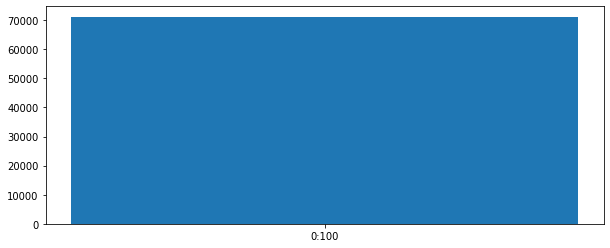

In [ ]:
token_len_sort = sorted({i:j for i, j in zip(train_df['token_len_cate'].value_counts().keys(), train_df['token_len_cate'].value_counts().values)}.items(), key=lambda x:x[0])
x = [i for (i,_) in token_len_sort]
y = [i for (_,i) in token_len_sort]
print(y)

plt.figure(figsize=(10, 4))
plt.bar(x, y)
plt.show()

In [ ]:
train_df.describe()

,token_len
count,71205.000000
mean,18.017457
std,2.470469
min,10.000000
25%,16.000000
50%,18.000000
75%,20.000000
max,29.000000


## Data split

In [ ]:
filtering_train_df = train_df.copy()

In [ ]:
cut = round(len(filtering_train_df) * 0.8)
filtering_train_df, filtering_test_df = filtering_train_df[:cut], filtering_train_df[cut:]

In [ ]:
filtering_test_df = filtering_test_df.reset_index(drop=True)

In [ ]:
print(len(filtering_train_df))
len(filtering_test_df)

56964


14241

## 학습을 위해 토큰으로 자르기

In [ ]:
filtering_train_df['split_train_token'] = ['<esp> ' + i.strip().replace('&&', ' <esp> ') + ' <esp>' for i in filtering_train_df['train']]
filtering_train_df['split_label_token'] = ['<esp> ' + i.strip() + ' <esp>' for i in filtering_train_df['label']]

In [ ]:
filtering_train_df.head()

,train,label,token_len,token_len_cate,split_train_token,split_label_token
0,JUMBO BAG RED WHITE SPOTTY&&JUMBO BAG PINK WIT...,LUNCH BAG PINK RETROSPOT,20,0:100,<esp> JUMBO BAG RED WHITE SPOTTY <esp> JUMBO B...,<esp> LUNCH BAG PINK RETROSPOT <esp>
1,PLEASE ONE PERSON METAL SIGN&&NATURAL SLATE HE...,NATURAL SLATE CHALKBOARD LARGE,19,0:100,<esp> PLEASE ONE PERSON METAL SIGN <esp> NATUR...,<esp> NATURAL SLATE CHALKBOARD LARGE <esp>
2,JUMBO BAG WOODLAND ANIMALS&&STRAWBERRY CANDY B...,WOODLAND CHARLOTTE BAG,13,0:100,<esp> JUMBO BAG WOODLAND ANIMALS <esp> STRAWBE...,<esp> WOODLAND CHARLOTTE BAG <esp>
3,PINK DOUGHNUT TRINKET POT&&VINTAGE HEADS AND T...,COFFEE MUG BLUE PAISLEY DESIGN,20,0:100,<esp> PINK DOUGHNUT TRINKET POT <esp> VINTAGE ...,<esp> COFFEE MUG BLUE PAISLEY DESIGN <esp>
4,3D HEARTS HONEYCOMB PAPER GARLAND&&SPOTTY HO...,ORIENTAL BLUE C/COVER,23,0:100,<esp> 3D HEARTS HONEYCOMB PAPER GARLAND <esp>...,<esp> ORIENTAL BLUE C/COVER <esp>


In [ ]:
MAX_LENGTH = 128

In [ ]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(filtering_train_df['split_train_token'] + filtering_train_df['split_label_token'], target_vocab_size=2**13)

In [ ]:
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
VOCAB_SIZE = tokenizer.vocab_size + 2

In [ ]:
print('시작 토큰 번호 :',START_TOKEN)
print('종료 토큰 번호 :',END_TOKEN)
print('단어 집합의 크기 :',VOCAB_SIZE)

시작 토큰 번호 : [2717]
종료 토큰 번호 : [2718]
단어 집합의 크기 : 2719


In [ ]:
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []

  for (sentence1, sentence2) in zip(inputs, outputs):
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    tokenized_inputs.append(sentence1)
    tokenized_outputs.append(sentence2)

  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

  return tokenized_inputs, tokenized_outputs

In [ ]:
train_token, label_token = tokenize_and_filter(filtering_train_df['split_train_token'], filtering_train_df['split_label_token'])

In [ ]:
print('질문 데이터의 크기(shape) :', train_token.shape)
print('답변 데이터의 크기(shape) :', label_token.shape)

질문 데이터의 크기(shape) : (56964, 128)
답변 데이터의 크기(shape) : (56964, 128)


## GPU 작동 확인

In [ ]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
!nvidia-smi

Fri May  7 09:44:34 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    26W /  70W |    222MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 학습

In [ ]:
# 텐서플로우 dataset을 이용하여 셔플(shuffle)을 수행하되, 배치 크기로 데이터를 묶는다.
# 또한 이 과정에서 교사 강요(teacher forcing)을 사용하기 위해서 디코더의 입력과 실제값 시퀀스를 구성한다.
BATCH_SIZE = 256
BUFFER_SIZE = 20000

# 디코더의 실제값 시퀀스에서는 시작 토큰을 제거해야 한다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': train_token,
        'dec_inputs': label_token[:, :-1] # 디코더의 입력. 마지막 패딩 토큰이 제거된다.
    },
    {
        'outputs': label_token[:, 1:]  # 맨 처음 토큰이 제거된다. 다시 말해 시작 토큰이 제거된다.
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
def scaled_dot_product_attention(query, key, value, mask):
  """Calculate the attention weights. """
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # scale matmul_qk
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # add the mask to zero out padding tokens
  if mask is not None:
    logits += (mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k)
  attention_weights = tf.nn.softmax(logits, axis=-1)

  output = tf.matmul(attention_weights, value)

  return output

class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # linear layers
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # split heads
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # scaled dot-product attention
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # concatenation of heads
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # final linear layer
    outputs = self.dense(concat_attention)

    return outputs

def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)
    # apply sin to even index in the array
    sines = tf.math.sin(angle_rads[:, 0::2])
    # apply cos to odd index in the array
    cosines = tf.math.cos(angle_rads[:, 1::2])

    pos_encoding = tf.concat([sines, cosines], axis=-1)
    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
  
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
  
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)
  
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)
  
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)
  # mask the future tokens for decoder inputs at the 1st attention block
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)
  # mask the encoder outputs for the 2nd attention block
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [ ]:
tf.keras.backend.clear_session()

# NUM_LAYERS = 2
NUM_LAYERS = 1
D_MODEL = 128
NUM_HEADS = 4
UNITS = 256
DROPOUT = 0.2


model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

In [ ]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  # ensure labels have shape (batch_size, MAX_LENGTH - 1)
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [ ]:
EPOCHS = 10

In [ ]:
model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 128)    480512      inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [ ]:
model.fit(dataset, epochs=EPOCHS)

Epoch 1/10
223/223 [==============================] - 38s 144ms/step - loss: 0.6928 - accuracy: 0.0059
Epoch 2/10
223/223 [==============================] - 32s 145ms/step - loss: 0.4436 - accuracy: 0.0449
Epoch 3/10
223/223 [==============================] - 33s 147ms/step - loss: 0.2375 - accuracy: 0.0575
Epoch 4/10
223/223 [==============================] - 33s 149ms/step - loss: 0.1634 - accuracy: 0.0661
Epoch 5/10
223/223 [==============================] - 33s 148ms/step - loss: 0.1205 - accuracy: 0.0706
Epoch 6/10
223/223 [==============================] - 33s 148ms/step - loss: 0.0940 - accuracy: 0.0743
Epoch 7/10
223/223 [==============================] - 33s 149ms/step - loss: 0.0781 - accuracy: 0.0765
Epoch 8/10
223/223 [==============================] - 33s 148ms/step - loss: 0.0689 - accuracy: 0.0777
Epoch 9/10
223/223 [==============================] - 33s 148ms/step - loss: 0.0636 - accuracy: 0.0783
Epoch 10/10
223/223 [==============================] - 33s 148ms/step - l

In [ ]:
# model.save_weights(path+f'Instacart_Transformer_{EPOCHS}_weights_layers_{NUM_LAYERS}')

In [ ]:
# model.load_weights(path+f'Instacart_Transformer_{EPOCHS}_weights_layers_{NUM_LAYERS}')

## 검증

In [ ]:
def evaluate(sentence):
  sentence = preprocess_sentence(sentence)

  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  output = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 예측 시작
  for i in range(MAX_LENGTH):
    predictions = model(inputs=[sentence, output], training=False)

    # 현재(마지막) 시점의 예측 단어를 받아온다.
    predictions = predictions[:, -1:, :]
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 마지막 시점의 예측 단어가 종료 토큰이라면 예측을 중단
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 마지막 시점의 예측 단어를 출력에 연결한다.
    # 이는 for문을 통해서 디코더의 입력으로 사용될 예정이다.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0)


def predict(sentence):
  prediction = evaluate(sentence)

  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

#   print('Input: {}'.format(sentence))
#   print('Output: {}'.format(predicted_sentence))

  return predicted_sentence


def preprocess_sentence(sentence):
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = sentence.strip()
  return sentence

In [ ]:
predict(filtering_train_df['split_label_token'][2])

'<esp> RED SPOTTY CHARLOTTE BAG <esp>'

In [ ]:
filtering_test_df['split_train_token'] = ['<esp> ' + i.strip().replace('&&', ' <esp> ') + ' <esp>' for i in filtering_test_df['train']]
filtering_test_df['split_label_token'] = ['<esp> ' + i.strip() + ' <esp>' for i in filtering_test_df['label']]

In [ ]:
filtering_test_df.pop('token_len')
filtering_test_df.pop('token_len_cate')
filtering_test_df.head()

,train,label,split_train_token,split_label_token
0,DANISH ROSE PHOTO FRAME&&RETRO BLUE SPOTTY WAS...,WOODEN UNION JACK BUNTING,<esp> DANISH ROSE PHOTO FRAME <esp> RETRO BLUE...,<esp> WOODEN UNION JACK BUNTING <esp>
1,SET OF 2 ROUND TINS DUTCH CHEESE&&LARGE MEDINA...,LOVE BUILDING BLOCK WORD,<esp> SET OF 2 ROUND TINS DUTCH CHEESE <esp> L...,<esp> LOVE BUILDING BLOCK WORD <esp>
2,PINK 3 PIECE MINI DOTS CUTLERY SET&&CHILDS APR...,MINI JIGSAW SPACEBOY,<esp> PINK 3 PIECE MINI DOTS CUTLERY SET <esp>...,<esp> MINI JIGSAW SPACEBOY <esp>
3,WOODEN BOX OF DOMINOES&&TEA TIME DES TEA COSY&...,GREEN GINGHAM FLOWER JEWELLERY BOX,<esp> WOODEN BOX OF DOMINOES <esp> TEA TIME DE...,<esp> GREEN GINGHAM FLOWER JEWELLERY BOX <esp>
4,ASSORTED COLOURS SILK FAN&&PACK OF 72 SKULL CA...,WORLD WAR 2 GLIDERS ASSTD DESIGNS,<esp> ASSORTED COLOURS SILK FAN <esp> PACK OF ...,<esp> WORLD WAR 2 GLIDERS ASSTD DESIGNS <esp>


In [ ]:
tqdm.tqdm.pandas()
predict_item_test = filtering_test_df['split_train_token'].progress_apply(predict)

100%|██████████| 14241/14241 [1:24:46<00:00,  2.80it/s]


In [ ]:
filtering_test_df['predict_item'] = predict_item_test
pd.Series([i in list(filtering_test_df['split_label_token']) for i in filtering_test_df['predict_item']]).value_counts()

True     14202
False       39
dtype: int64

In [ ]:
filtering_test_df

,train,label,split_train_token,split_label_token,predict_item
0,DANISH ROSE PHOTO FRAME&&RETRO BLUE SPOTTY WAS...,WOODEN UNION JACK BUNTING,<esp> DANISH ROSE PHOTO FRAME <esp> RETRO BLUE...,<esp> WOODEN UNION JACK BUNTING <esp>,<esp> HOT BATHS METAL SIGN <esp>
1,SET OF 2 ROUND TINS DUTCH CHEESE&&LARGE MEDINA...,LOVE BUILDING BLOCK WORD,<esp> SET OF 2 ROUND TINS DUTCH CHEESE <esp> L...,<esp> LOVE BUILDING BLOCK WORD <esp>,<esp> RED SPOTTY APRON <esp>
2,PINK 3 PIECE MINI DOTS CUTLERY SET&&CHILDS APR...,MINI JIGSAW SPACEBOY,<esp> PINK 3 PIECE MINI DOTS CUTLERY SET <esp>...,<esp> MINI JIGSAW SPACEBOY <esp>,<esp> RED 3 PIECE MINI DOTS CUTLERY SET <esp>
3,WOODEN BOX OF DOMINOES&&TEA TIME DES TEA COSY&...,GREEN GINGHAM FLOWER JEWELLERY BOX,<esp> WOODEN BOX OF DOMINOES <esp> TEA TIME DE...,<esp> GREEN GINGHAM FLOWER JEWELLERY BOX <esp>,<esp> RED SPOTTY BISCUIT TIN <esp>
4,ASSORTED COLOURS SILK FAN&&PACK OF 72 SKULL CA...,WORLD WAR 2 GLIDERS ASSTD DESIGNS,<esp> ASSORTED COLOURS SILK FAN <esp> PACK OF ...,<esp> WORLD WAR 2 GLIDERS ASSTD DESIGNS <esp>,<esp> SET OF 72 RETRO SPOT PAPER DOILIES <esp>
...,...,...,...,...,...
14236,ASSORTED COLOUR BIRD ORNAMENT&&FILIGRIS HEART ...,HANGING WOOD AND FELT HEART,<esp> ASSORTED COLOUR BIRD ORNAMENT <esp> FILI...,<esp> HANGING WOOD AND FELT HEART <esp>,<esp> HANGING HEART ZINC T-LIGHT HOLDER <esp>
14237,LADLE LOVE HEART RED&&FAWN AND MUSHROOM GREETI...,SET/6 RED SPOTTY PAPER PLATES,<esp> LADLE LOVE HEART RED <esp> FAWN AND MUSH...,<esp> SET/6 RED SPOTTY PAPER PLATES <esp>,<esp> PACK OF 72 RETRO SPOT CAKE CASES <esp>
14238,GOLD CHERRY LIGHTS&&URBAN CHIC CHOPSTICKS SET...,WOBBLING METAL CHICKEN EASTER,<esp> GOLD CHERRY LIGHTS <esp> URBAN CHIC CHO...,<esp> WOBBLING METAL CHICKEN EASTER <esp>,<esp> PINK FAIRY CAKE CHILD'S APRON <esp>
14239,SET/2 RED SPOTTY TEA TOWELS&&ABSTRACT CIRCLES ...,HOME SWEET HOME BLACKBOARD,<esp> SET/2 RED SPOTTY TEA TOWELS <esp> ABSTRA...,<esp> HOME SWEET HOME BLACKBOARD <esp>,<esp> DOOR MAT UNION FLAG <esp>


# Product2Vec

In [ ]:
TFoutputs = filtering_test_df

In [ ]:
checker = pd.Series([i in list(TFoutputs['split_label_token']) for i in TFoutputs['predict_item']])
print(checker.value_counts())
filter = checker[checker == False].index
len(filter)

True     14202
False       39
dtype: int64


39

In [ ]:
TFoutputs['filter'] = checker
TFoutputs

,train,label,split_train_token,split_label_token,predict_item,filter
0,DANISH ROSE PHOTO FRAME&&RETRO BLUE SPOTTY WAS...,WOODEN UNION JACK BUNTING,<esp> DANISH ROSE PHOTO FRAME <esp> RETRO BLUE...,<esp> WOODEN UNION JACK BUNTING <esp>,<esp> HOT BATHS METAL SIGN <esp>,True
1,SET OF 2 ROUND TINS DUTCH CHEESE&&LARGE MEDINA...,LOVE BUILDING BLOCK WORD,<esp> SET OF 2 ROUND TINS DUTCH CHEESE <esp> L...,<esp> LOVE BUILDING BLOCK WORD <esp>,<esp> RED SPOTTY APRON <esp>,True
2,PINK 3 PIECE MINI DOTS CUTLERY SET&&CHILDS APR...,MINI JIGSAW SPACEBOY,<esp> PINK 3 PIECE MINI DOTS CUTLERY SET <esp>...,<esp> MINI JIGSAW SPACEBOY <esp>,<esp> RED 3 PIECE MINI DOTS CUTLERY SET <esp>,True
3,WOODEN BOX OF DOMINOES&&TEA TIME DES TEA COSY&...,GREEN GINGHAM FLOWER JEWELLERY BOX,<esp> WOODEN BOX OF DOMINOES <esp> TEA TIME DE...,<esp> GREEN GINGHAM FLOWER JEWELLERY BOX <esp>,<esp> RED SPOTTY BISCUIT TIN <esp>,True
4,ASSORTED COLOURS SILK FAN&&PACK OF 72 SKULL CA...,WORLD WAR 2 GLIDERS ASSTD DESIGNS,<esp> ASSORTED COLOURS SILK FAN <esp> PACK OF ...,<esp> WORLD WAR 2 GLIDERS ASSTD DESIGNS <esp>,<esp> SET OF 72 RETRO SPOT PAPER DOILIES <esp>,True
...,...,...,...,...,...,...
14236,ASSORTED COLOUR BIRD ORNAMENT&&FILIGRIS HEART ...,HANGING WOOD AND FELT HEART,<esp> ASSORTED COLOUR BIRD ORNAMENT <esp> FILI...,<esp> HANGING WOOD AND FELT HEART <esp>,<esp> HANGING HEART ZINC T-LIGHT HOLDER <esp>,True
14237,LADLE LOVE HEART RED&&FAWN AND MUSHROOM GREETI...,SET/6 RED SPOTTY PAPER PLATES,<esp> LADLE LOVE HEART RED <esp> FAWN AND MUSH...,<esp> SET/6 RED SPOTTY PAPER PLATES <esp>,<esp> PACK OF 72 RETRO SPOT CAKE CASES <esp>,True
14238,GOLD CHERRY LIGHTS&&URBAN CHIC CHOPSTICKS SET...,WOBBLING METAL CHICKEN EASTER,<esp> GOLD CHERRY LIGHTS <esp> URBAN CHIC CHO...,<esp> WOBBLING METAL CHICKEN EASTER <esp>,<esp> PINK FAIRY CAKE CHILD'S APRON <esp>,True
14239,SET/2 RED SPOTTY TEA TOWELS&&ABSTRACT CIRCLES ...,HOME SWEET HOME BLACKBOARD,<esp> SET/2 RED SPOTTY TEA TOWELS <esp> ABSTRA...,<esp> HOME SWEET HOME BLACKBOARD <esp>,<esp> DOOR MAT UNION FLAG <esp>,True


In [ ]:
pred = TFoutputs['predict_item']
pred = pred.str.replace('<esp>', '')
pred = pred.str.strip()
pred.head()

0                   HOT BATHS METAL SIGN
1                       RED SPOTTY APRON
2      RED 3 PIECE MINI DOTS CUTLERY SET
3                 RED SPOTTY BISCUIT TIN
4    SET OF 72 RETRO SPOT PAPER  DOILIES
Name: predict_item, dtype: object

In [ ]:
falses = pd.Series([TFoutputs['predict_item'][i] for i in filter])
falses = falses.str.replace('<esp>', '')
falses = falses.str.strip()
print(len(falses))
falses.head()

39


0    BOTANICAL LAVENDER GIFT WRAP
1    BOTANICAL LAVENDER GIFT WRAP
2     PINK PATCH PURSE PINK HEART
3    BOTANICAL LAVENDER GIFT WRAP
4    BOTANICAL LAVENDER GIFT WRAP
dtype: object

In [ ]:
filter[:5]

Int64Index([972, 1016, 1112, 1222, 1675], dtype='int64')

In [ ]:
df = ds_customer
df

,Customer,Detail,label
0,32346.0,DOORMAT HOME SWEET HOME BLUE&&DOORMAT SPOTTY H...,RED SPOTTY CHILDS UMBRELLA
1,32349.0,RETRO SPOT LARGE MILK JUG&&POLKADOT CUTLERY 24...,SET/6 RED SPOTTY PAPER CUPS
2,32355.0,GOLD TEDDY BEAR&&OPULENT VELVET SET/3 CANDLES&...,KIDS RAIN MAC BLUE
3,32358.0,JUMBO SHOPPER VINTAGE RED PAISLEY&&GARDEN PATH...,ASSORTED CHEESE FRIDGE MAGNETS
4,32359.0,SET OF 2 WOODEN MARKET CRATES&&OLD DOC RUSSEL ...,LAUNDRY 15C METAL SIGN
...,...,...,...
2727,38276.0,LUNCH BAG SPACEBOY DESIGN&&SET OF 72 SKULL PAP...,LUNCH BAG BLACK SKULL.
2728,38281.0,TEA PARTY BIRTHDAY CARD&&LUNCH BAG PINK RETROS...,SPACEBOY BIRTHDAY CARD
2729,38283.0,SMALL POPCORN HOLDER&&ASSORTED ICE CREAM FRIDG...,RED SPOTTY CHILDS APRON
2730,38285.0,GLASS HEART T-LIGHT HOLDER&&SMALL GLASS SUNDAE...,CAKE STAND VICTORIAN FILIGREE SMALL


In [ ]:
user2item = df.copy()

In [ ]:
user2item.columns = ['유저 식별키', '유저 구매 상품 식별키 묶음', '라벨']
user2item

,유저 식별키,유저 구매 상품 식별키 묶음,라벨
0,32346.0,DOORMAT HOME SWEET HOME BLUE&&DOORMAT SPOTTY H...,RED SPOTTY CHILDS UMBRELLA
1,32349.0,RETRO SPOT LARGE MILK JUG&&POLKADOT CUTLERY 24...,SET/6 RED SPOTTY PAPER CUPS
2,32355.0,GOLD TEDDY BEAR&&OPULENT VELVET SET/3 CANDLES&...,KIDS RAIN MAC BLUE
3,32358.0,JUMBO SHOPPER VINTAGE RED PAISLEY&&GARDEN PATH...,ASSORTED CHEESE FRIDGE MAGNETS
4,32359.0,SET OF 2 WOODEN MARKET CRATES&&OLD DOC RUSSEL ...,LAUNDRY 15C METAL SIGN
...,...,...,...
2727,38276.0,LUNCH BAG SPACEBOY DESIGN&&SET OF 72 SKULL PAP...,LUNCH BAG BLACK SKULL.
2728,38281.0,TEA PARTY BIRTHDAY CARD&&LUNCH BAG PINK RETROS...,SPACEBOY BIRTHDAY CARD
2729,38283.0,SMALL POPCORN HOLDER&&ASSORTED ICE CREAM FRIDG...,RED SPOTTY CHILDS APRON
2730,38285.0,GLASS HEART T-LIGHT HOLDER&&SMALL GLASS SUNDAE...,CAKE STAND VICTORIAN FILIGREE SMALL


# Product2Vector 생성

### Jaccard 유사도

In [ ]:
detail = detail.tolist()
len(detail)

3485

In [ ]:
def JaccardSimilarity(inp1, inp2):
    list_inp1 = inp1.split()
    list_inp2 = inp2.split()
    mom = set(list_inp1).union(set(list_inp2))
    son = set(list_inp1).intersection(set(list_inp2))
    # print(mom)
    # print(son)
    return len(son)/len(mom)

In [ ]:
pd.Series([i in detail for i in pred]).value_counts()

True     14223
False       18
dtype: int64

In [ ]:
asdf = []

for v in falses:
    m = 0
    for d in detail:
        score = JaccardSimilarity(v, d)
        if m < score:
            m = score
            temp = d
    if m == 0: asdf.append(v)
    id = pred[pred == v].index
    for i in id:
        pred[i] = temp

len(asdf)

0

In [ ]:
pd.Series([i in detail for i in pred]).value_counts()

True    14241
dtype: int64

In [ ]:
changes = pd.DataFrame(columns=['Original', 'Changed'])
changes['Original'] = falses
changes['Changed'] = pred[filter].to_list()
changes

,Original,Changed
0,BOTANICAL LAVENDER GIFT WRAP,BOTANICAL LAVENDER GIFT WRAP
1,BOTANICAL LAVENDER GIFT WRAP,BOTANICAL LAVENDER GIFT WRAP
2,PINK PATCH PURSE PINK HEART,BLUE PATCH PURSE PINK HEART
3,BOTANICAL LAVENDER GIFT WRAP,BOTANICAL LAVENDER GIFT WRAP
4,BOTANICAL LAVENDER GIFT WRAP,BOTANICAL LAVENDER GIFT WRAP
5,PINK PATCH PURSE PINK HEART,BLUE PATCH PURSE PINK HEART
6,BOTANICAL LAVENDER GIFT WRAP,BOTANICAL LAVENDER GIFT WRAP
7,PINK PATCH PURSE PINK HEART,BLUE PATCH PURSE PINK HEART
8,PINK PATCH PURSE PINK HEART,BLUE PATCH PURSE PINK HEART
9,ANT COPPER PINK BOUDICCA BRACELET,ANT COPPER PINK BOUDICCA BRACELET


### Word2vec Model 학습

In [ ]:
model = Word2Vec([item_list.split('&&') for item_list in user2item['유저 구매 상품 식별키 묶음']], size=100, window=5, min_count=1, negative=15, iter=20, sample=0.00001, sg=1)

In [ ]:
# 유저 성향 벡터 구하기 
user_propensity_vector = []
for item_list in tqdm_notebook(user2item['유저 구매 상품 식별키 묶음']):
    item_list = item_list.split('&&')
    bbb = np.array(np.ones(100))
    for aaa in item_list:
        bbb *= model[aaa]
        bbb = bbb/norm(bbb)
    user_propensity_vector.append(bbb)

In [ ]:
def find_item(item, n=10):
    return list(dict(model.wv.most_similar(item, topn=n)))

In [ ]:
find_item(pred[0])

['NO SINGING METAL SIGN',
 'AREA PATROLLED METAL SIGN',
 'HEART OF WICKER LARGE',
 'BOMBS AWAY METAL SIGN',
 'WASHROOM METAL SIGN',
 'BATHROOM METAL SIGN',
 'LADIES & GENTLEMEN METAL SIGN',
 "YOU'RE CONFUSING ME METAL SIGN",
 'METAL SIGN EMPIRE TEA',
 'PLEASE ONE PERSON  METAL SIGN']

## 구매전 : Top-10 시나리오

In [ ]:
def recommend(n=10, acc=False, pred=pred, TFoutputs=TFoutputs):
    item_list = []
    for v in tqdm_notebook(pred.to_list()):
        if n > 1:
            pp = find_item(v, n-1)
            pp.insert(0, v)
            item_list.append(pp)
        else: item_list.append(v)
    TFoutputs['추천 list'] = item_list
    TFoutputs['정답 유무'] = [True if label in item else False for label, item in tqdm_notebook(zip(TFoutputs['label'], TFoutputs['추천 list']), total=(len(TFoutputs)))]
    # 추천 알고리듬 구매전 Top-10 성능평가
    
    if acc:
        return TFoutputs[TFoutputs['정답 유무']==True].shape[0]/(TFoutputs.shape[0])

    return TFoutputs

In [ ]:
recommend(n=5, acc=True)

0.05013692858647567

In [ ]:
recommend(n=10, acc=True)

0.07401165648479742

In [ ]:
recommend(n=20, acc=True)

0.1042061652973808

In [ ]:
recommend()

,train,label,split_train_token,split_label_token,predict_item,filter,추천 list,정답 유무
0,DANISH ROSE PHOTO FRAME&&RETRO BLUE SPOTTY WAS...,WOODEN UNION JACK BUNTING,<esp> DANISH ROSE PHOTO FRAME <esp> RETRO BLUE...,<esp> WOODEN UNION JACK BUNTING <esp>,<esp> HOT BATHS METAL SIGN <esp>,True,"[HOT BATHS METAL SIGN, NO SINGING METAL SIGN, ...",False
1,SET OF 2 ROUND TINS DUTCH CHEESE&&LARGE MEDINA...,LOVE BUILDING BLOCK WORD,<esp> SET OF 2 ROUND TINS DUTCH CHEESE <esp> L...,<esp> LOVE BUILDING BLOCK WORD <esp>,<esp> RED SPOTTY APRON <esp>,True,"[RED SPOTTY APRON, RETRO SPOT MUG, RETRO SPOT ...",False
2,PINK 3 PIECE MINI DOTS CUTLERY SET&&CHILDS APR...,MINI JIGSAW SPACEBOY,<esp> PINK 3 PIECE MINI DOTS CUTLERY SET <esp>...,<esp> MINI JIGSAW SPACEBOY <esp>,<esp> RED 3 PIECE MINI DOTS CUTLERY SET <esp>,True,"[RED 3 PIECE MINI DOTS CUTLERY SET, PINK 3 PIE...",False
3,WOODEN BOX OF DOMINOES&&TEA TIME DES TEA COSY&...,GREEN GINGHAM FLOWER JEWELLERY BOX,<esp> WOODEN BOX OF DOMINOES <esp> TEA TIME DE...,<esp> GREEN GINGHAM FLOWER JEWELLERY BOX <esp>,<esp> RED SPOTTY BISCUIT TIN <esp>,True,"[RED SPOTTY BISCUIT TIN, RED SPOTTY OVEN GLOVE...",False
4,ASSORTED COLOURS SILK FAN&&PACK OF 72 SKULL CA...,WORLD WAR 2 GLIDERS ASSTD DESIGNS,<esp> ASSORTED COLOURS SILK FAN <esp> PACK OF ...,<esp> WORLD WAR 2 GLIDERS ASSTD DESIGNS <esp>,<esp> SET OF 72 RETRO SPOT PAPER DOILIES <esp>,True,"[SET OF 72 RETRO SPOT PAPER DOILIES, SET/20 R...",False
...,...,...,...,...,...,...,...,...
14236,ASSORTED COLOUR BIRD ORNAMENT&&FILIGRIS HEART ...,HANGING WOOD AND FELT HEART,<esp> ASSORTED COLOUR BIRD ORNAMENT <esp> FILI...,<esp> HANGING WOOD AND FELT HEART <esp>,<esp> HANGING HEART ZINC T-LIGHT HOLDER <esp>,True,"[HANGING HEART ZINC T-LIGHT HOLDER, SINGLE HEA...",False
14237,LADLE LOVE HEART RED&&FAWN AND MUSHROOM GREETI...,SET/6 RED SPOTTY PAPER PLATES,<esp> LADLE LOVE HEART RED <esp> FAWN AND MUSH...,<esp> SET/6 RED SPOTTY PAPER PLATES <esp>,<esp> PACK OF 72 RETRO SPOT CAKE CASES <esp>,True,"[PACK OF 72 RETRO SPOT CAKE CASES, SET/20 RED ...",False
14238,GOLD CHERRY LIGHTS&&URBAN CHIC CHOPSTICKS SET...,WOBBLING METAL CHICKEN EASTER,<esp> GOLD CHERRY LIGHTS <esp> URBAN CHIC CHO...,<esp> WOBBLING METAL CHICKEN EASTER <esp>,<esp> PINK FAIRY CAKE CHILD'S APRON <esp>,True,"[PINK FAIRY CAKE CHILD'S APRON, CHILDS APRON S...",False
14239,SET/2 RED SPOTTY TEA TOWELS&&ABSTRACT CIRCLES ...,HOME SWEET HOME BLACKBOARD,<esp> SET/2 RED SPOTTY TEA TOWELS <esp> ABSTRA...,<esp> HOME SWEET HOME BLACKBOARD <esp>,<esp> DOOR MAT UNION FLAG <esp>,True,"[DOOR MAT UNION FLAG, DOOR MAT FAIRY CAKE, DOO...",False
